# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install plotnine

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from helios import intensity_estimation


# Dataset and Subdivision

In [7]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# changing the month values for the year 2005 (1 = 13, 2 = 14, etc.) to make subdivision simpler later on
# in rows where the year value is 2005, add 12 to the month value and replace the old month value
df['month'] = np.where((df['year'] == 2005), df['month'] + 12, df['month'])

# list that will hold sets of 4 with a two month overlap
dfs = []

# grouping the data frame by month nummber
df_m = df.groupby(['month'])

# looping starting at i = 4, in steps of 2, while i < 25
# creates an overlap of two months between subsets
for i in range(4, 25, 2):
    # get groups for i - 3th, i - 2th, i - 1th, and ith months, 
    # concatenate them into a single data frame, then append this to the dfs list
    dfs.append(pd.concat([df_m.get_group(i - 3), df_m.get_group(i - 2), df_m.get_group(i - 1), df_m.get_group(i)]))

# Hotspot Discovery

## Finding Thresholds `d1` and `d2`

[2.86852820e-15 3.62701147e-07 5.97978777e-07 8.87228088e-07
 1.46239960e-06]


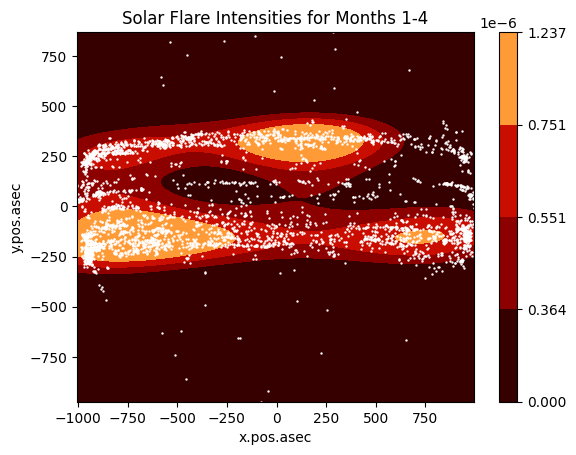

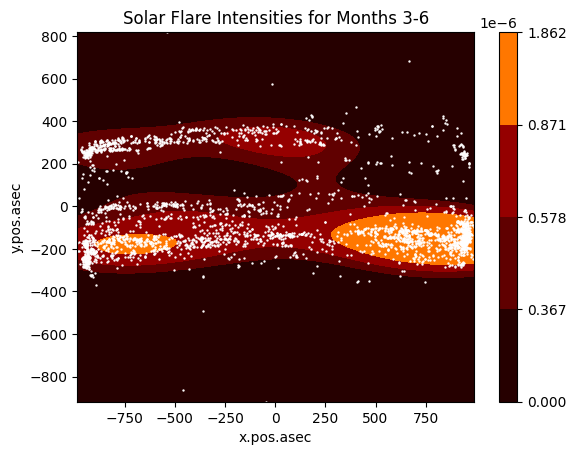

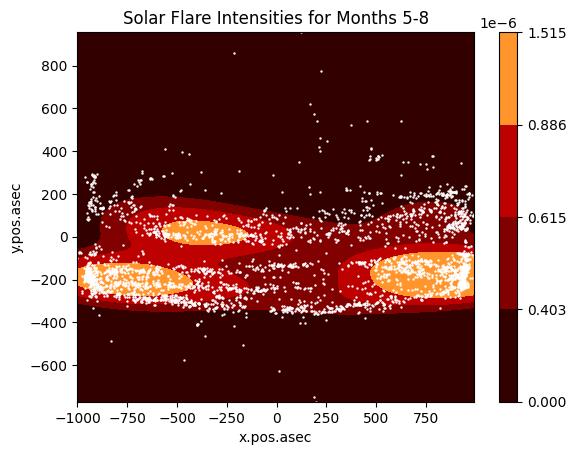

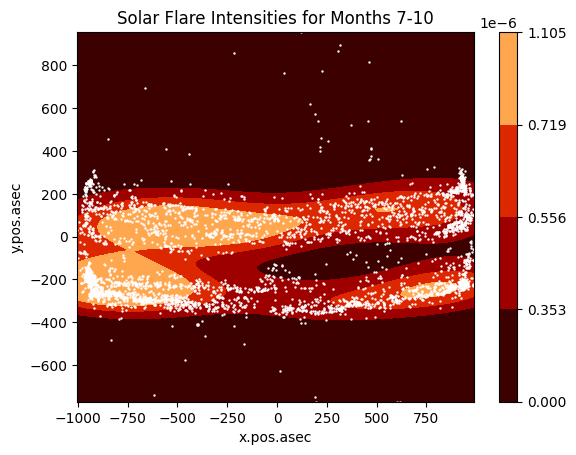

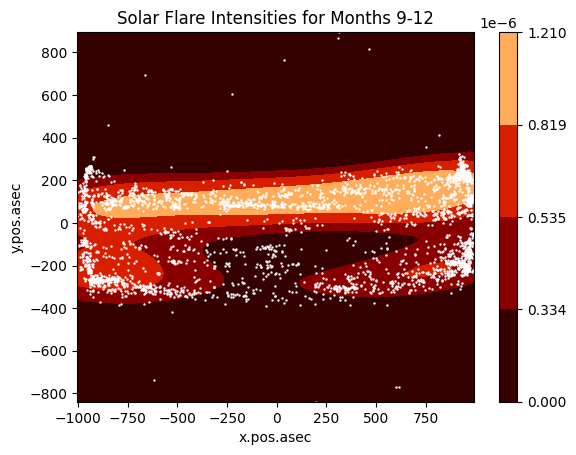

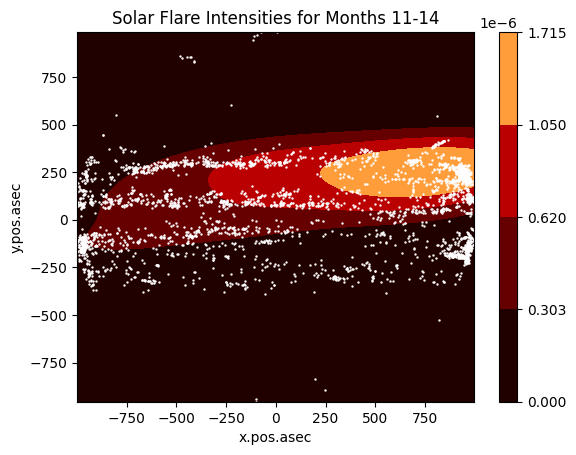

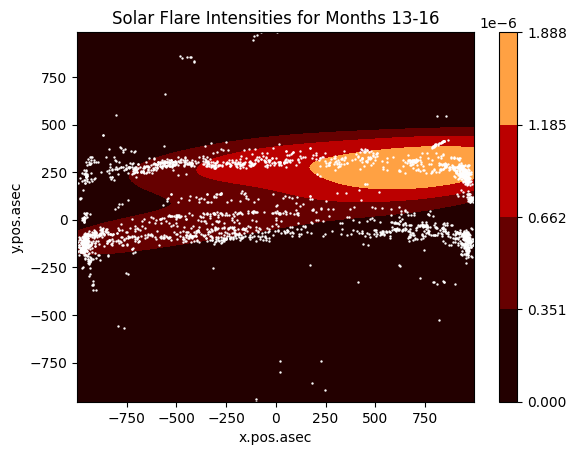

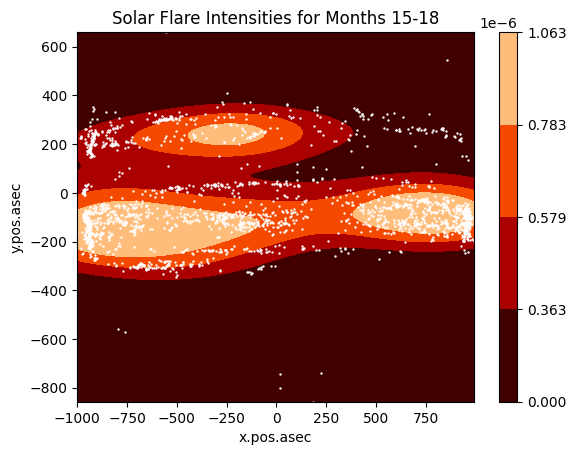

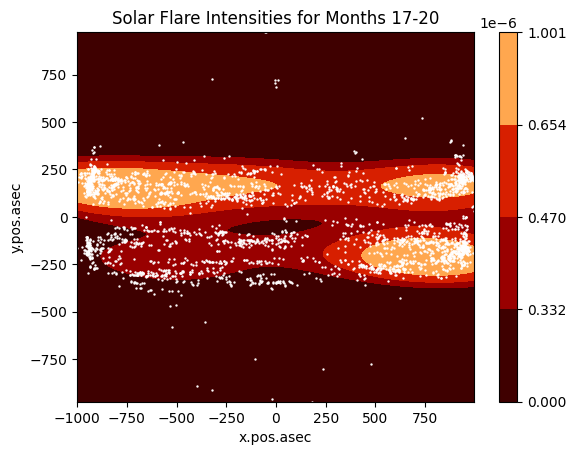

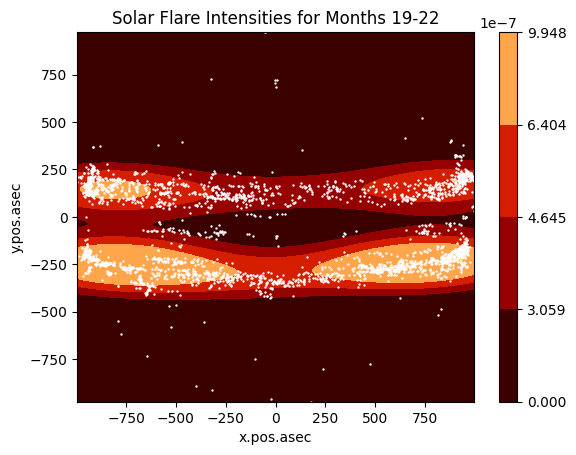

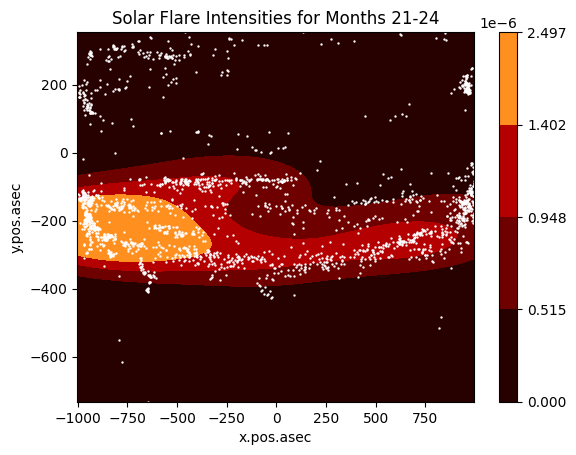

In [8]:
def thresholds(data):
    """For each subset of data, get the potential threshold values for hotspots"""
    
    ticks = []

    # loop through each subset
    for set in data:
        # append the potential threshold values to the ticks list
        # a level value of [0, 0.25, 0.5, 0.75, 1] will return 5 intensity values where each
        # corresponds with a probability mass of 0%, 25%, and so on
        ticks.append(intensity_estimation(set, plot=True, levels=[0, 0.25, 0.5, 0.75, 1]))
    
    # return the potential threshold values
    return ticks

# numpy mean will get the element-wise mean for all the potential threshold values
# from here, we can select the d1 and d2 threshold values from this list, like t[2] for the med
# hotspots and t[3] for the intense hotspots or something
t = np.mean(thresholds(dfs), axis=0)
print(t)

## Time Series Using `d1` and `d2` Threshold values

## Test for Spatial autocorrelation / clustering in data (optional)

## Create the hotspot map

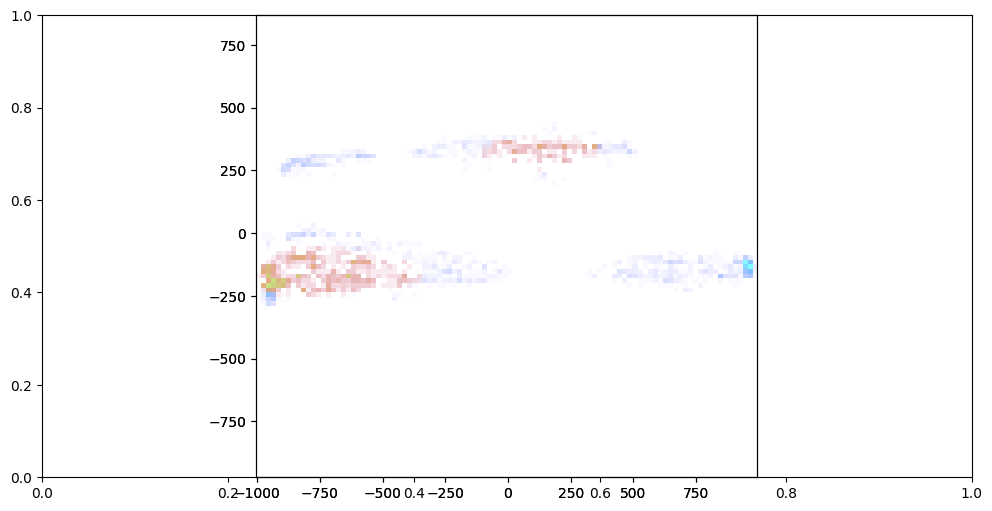

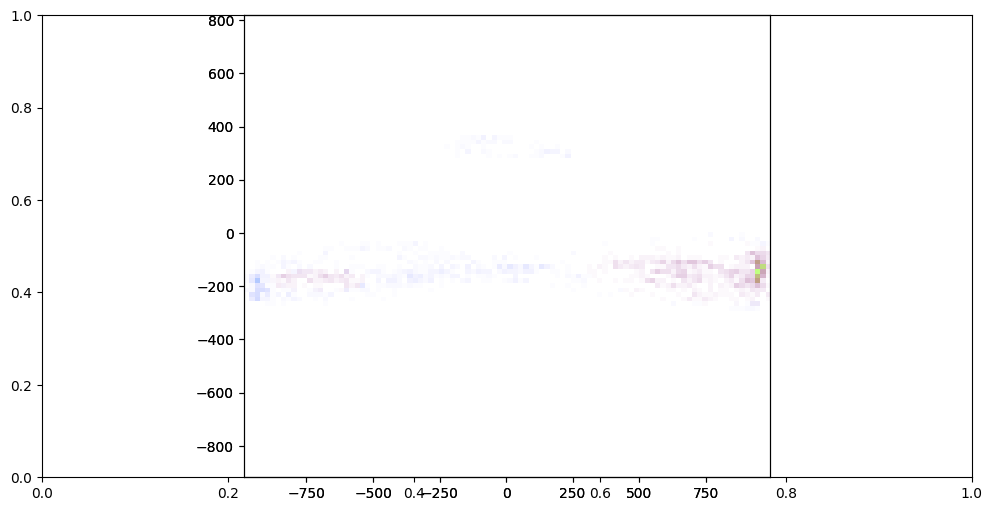

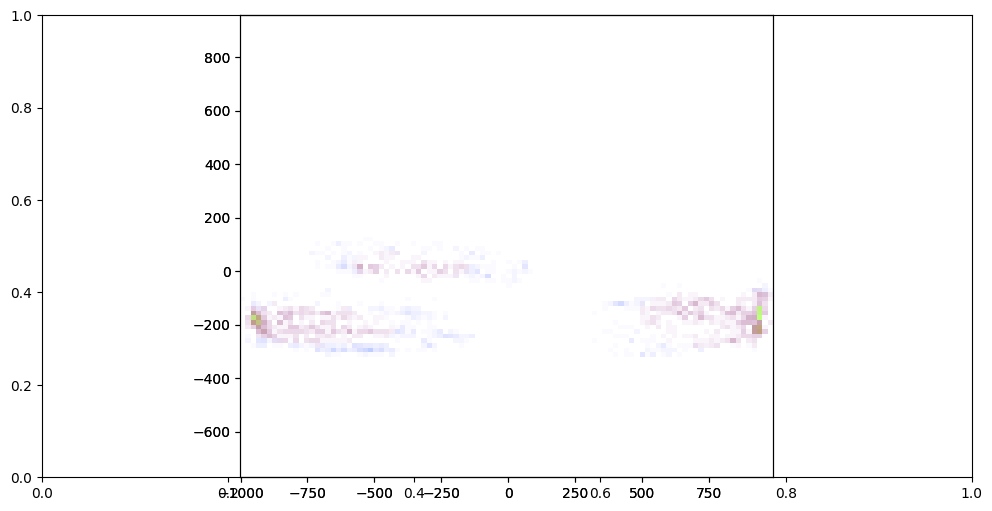

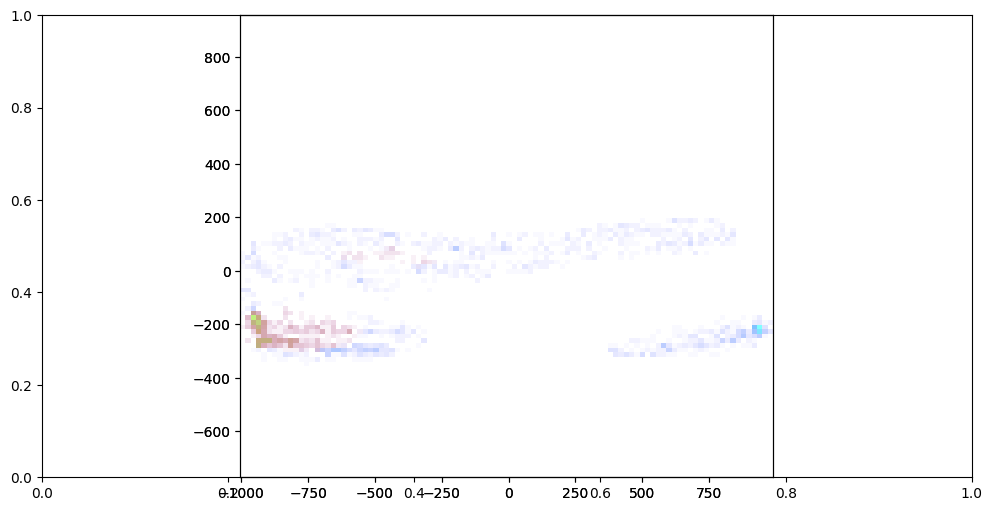

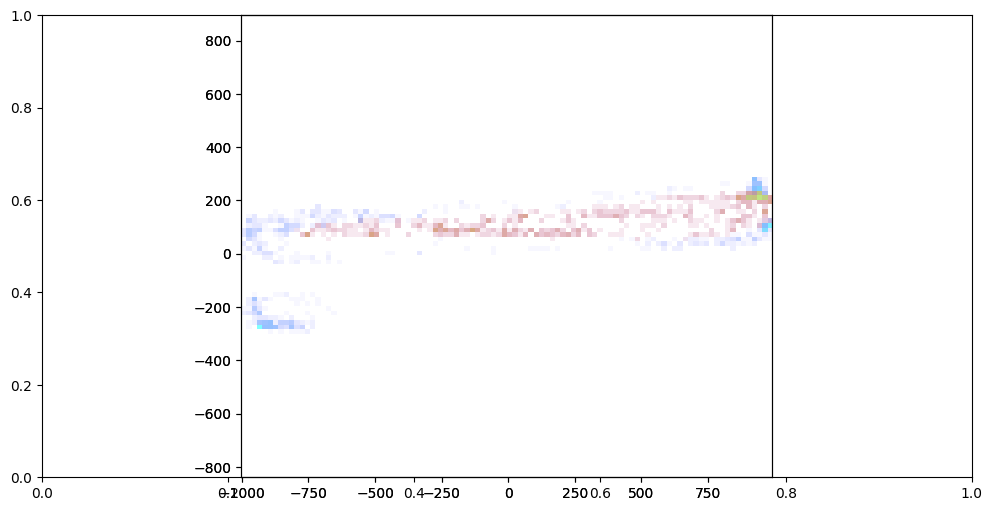

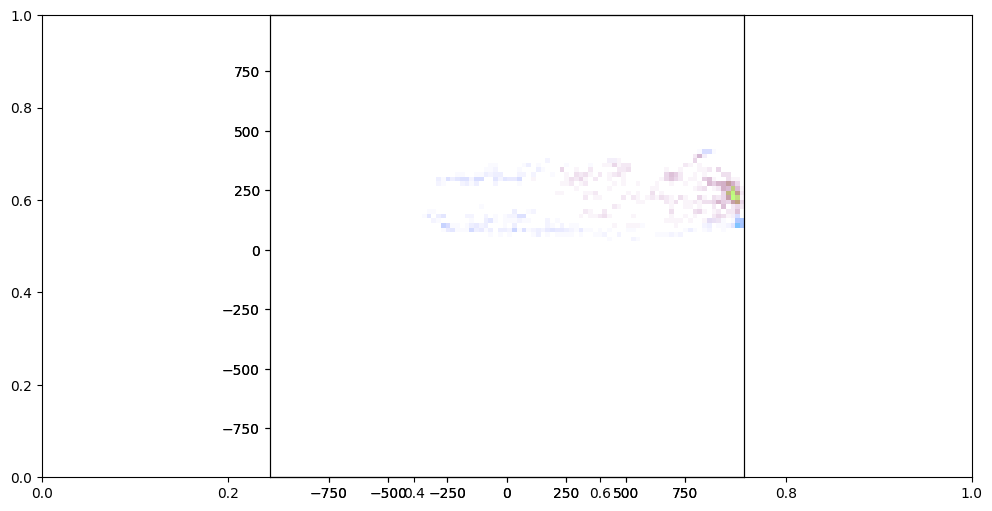

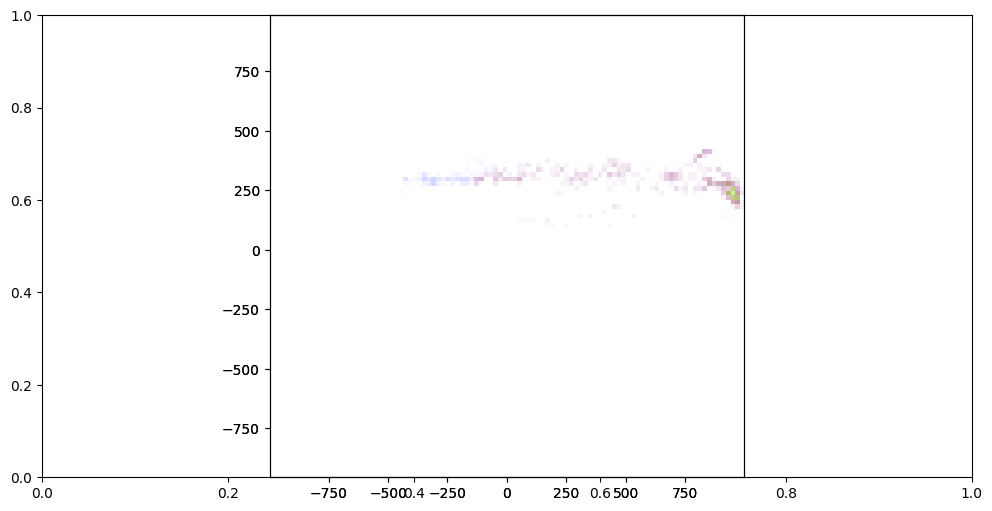

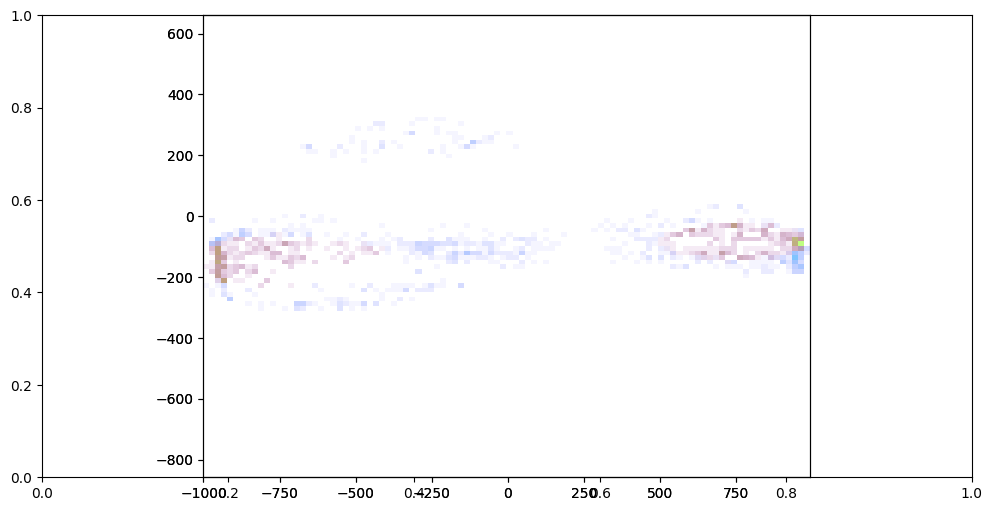

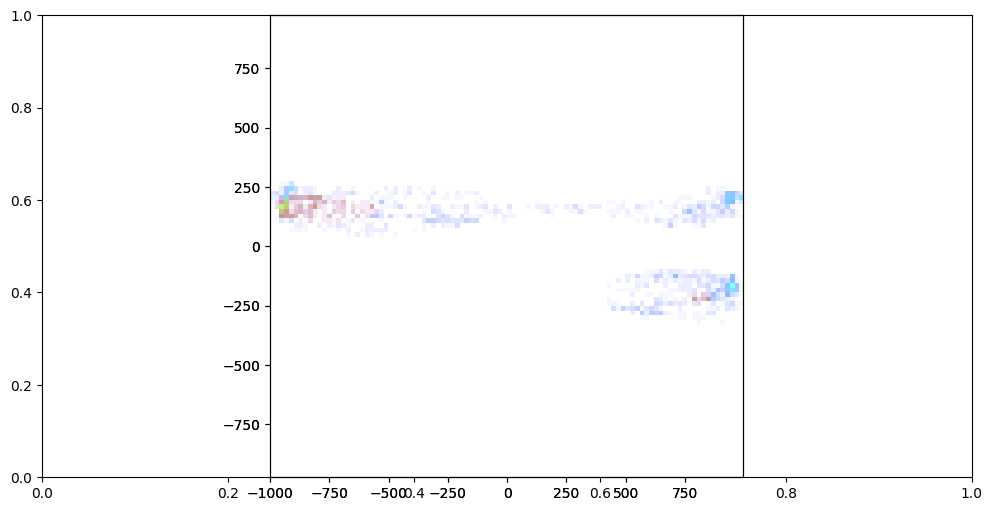

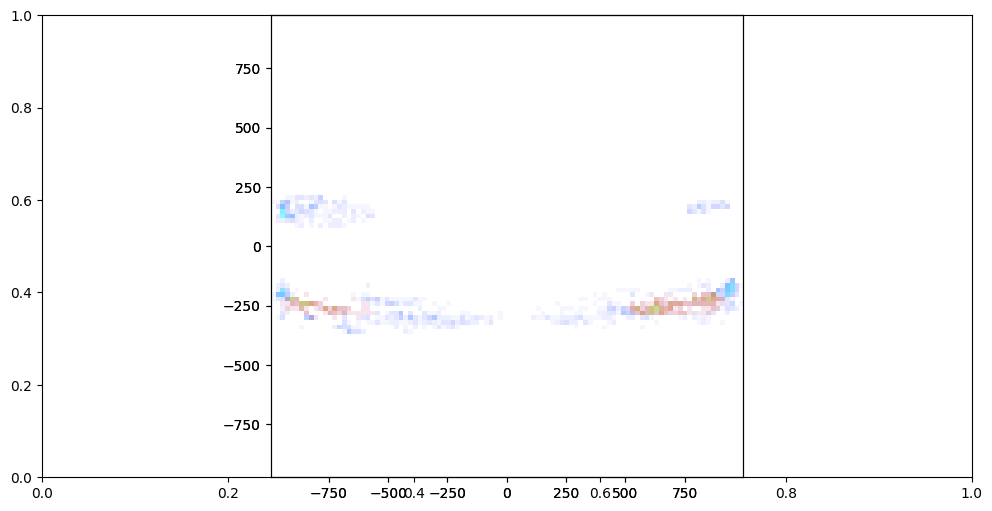

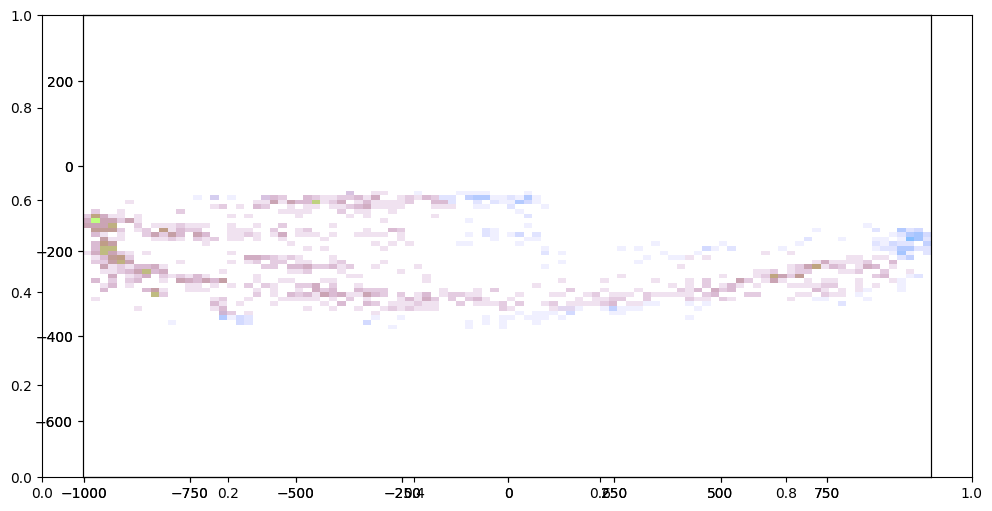

In [65]:
def create_blue_colormap():
    # Define your custom colormap with shades of blue
    colors = [(0, 0, 1, 0), (0, 0.5, 1, 1), (0, 1, 1, 1)]  # RGBA values (dark blue with transparency to light blue)
    cmap_name = 'custom_blue_colormap'
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

def create_red_colormap():
    # Define your custom red colormap
    colors = [(1, 0, 0, 0), (1, 0.5, 0, 1), (1, 1, 0, 1)]  # RGBA values (dark red with transparency to light red)
    cmap_name = 'custom_red_colormap'
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

def heatmap(data, threshold, ax, color_map, intensity_data):
    grid_size = (100, 100)  # rows, cols
    heatmap = np.zeros(grid_size)

    x_min, x_max = data['x.pos.asec'].min(), data['x.pos.asec'].max()
    y_min, y_max = data['y.pos.asec'].min(), data['y.pos.asec'].max()

    x_range = x_max - x_min
    y_range = y_max - y_min

    cell_width = x_range / grid_size[0]
    cell_height = y_range / grid_size[1]

    for index, row in data.iterrows():
        x, y = row['x.pos.asec'], row['y.pos.asec']
        intensity = row['intensity']

        col = int((x - x_min) / cell_width)
        row = int((y - y_min) / cell_height)

        if not (0 <= row < grid_size[1] and 0 <= col < grid_size[0]):
            continue

        if intensity >= threshold:
            heatmap[row, col] += 1

    ax.imshow(heatmap, cmap=color_map, origin='lower', extent=[x_min, x_max, y_min, y_max], alpha=1)

d1 = t[2]
d2 = t[3]

for data_segment in dfs:
    data_segment['intensity'] = intensity_estimation(data_segment)

    fig, background = plt.subplots(1, 1, figsize=(12, 6))
    ax1 = fig.add_axes(background.get_position(), zorder=1) 
    ax2 = fig.add_axes(background.get_position(), zorder=2)

    ax1.set_facecolor('none')
    ax2.set_facecolor('none')

    # fig1, ax1 = plt.subplots(1, 1, figsize=(12, 6))
    # fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))


    custom_blue_cmap = create_blue_colormap()
    custom_red_cmap = create_red_colormap()

    background.set_facecolor('white')

    heatmap(data_segment, d1, ax1, custom_blue_cmap, intensity_data) 
    heatmap(data_segment, d2, ax2, custom_red_cmap, intensity_data) 

    plt.show()

## Define the hotspot map legend threshold